<h1>Sistem Rekomendasi: Rekomendasi Film untuk Pengguna di Netflix Movies and TV Shows<h1>


---
Proyek Submission 2 - Machine Learning Terapan Dicoding

Dibuat oleh: [Kurnivan Noer Yusvianto](https://www.dicoding.com/users/kurnivan_ny)



<p align="center">
  <img width="500" height="250" src="https://user-images.githubusercontent.com/72246401/137863762-394d381d-7312-4ece-806a-cdf8565baddf.png">
</p>

# Pendahuluan

Pada proyek Machine Learning Terapan dari Dicoding, topik yang dibahas adalah sistem rekomendasi di Netflix Movies and TV Shows menggunakan _content based filtering_ karena tidak membutuhkan data rating dari pengguna.

#1. Mengimpor pustaka/modul python yang dibutuhkan

In [ ]:
# update modul python terbaru
!pip install -U scikit-learn
!pip install -q kaggle
!pip install rake_nltk
!pip install --upgrade tensorflow_hub

In [ ]:
# untuk mengunggah file ke google colab
from google.colab import files

# untuk pengolahan data
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from rake_nltk import Rake
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import warnings
warnings.filterwarnings("ignore")

# untuk visualisasi data
import matplotlib.pyplot as plt
import plotly.express as px
from wordcloud import WordCloud

# Untuk pembuatan sistem rekomendasi 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Untuk evaluasi sistem rekomendasi
from sklearn.metrics.pairwise import cosine_similarity

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#2. Mempersiapkan Dataset

![image](https://user-images.githubusercontent.com/72246401/137866422-f7eba1f6-e2b7-4f37-b2f2-d2c0df43cb97.png)

Informasi Data:

| Jenis | Keterangan |
| :--- | :--- |
| Sumber | Kaggle Dataset : [Netflix Movies and TV Shows](https://www.kaggle.com/shivamb/netflix-shows)|
| Lisensi | CC0: Public Domain |
| Kategori | movies and tv shows |
| Rating Penggunaan | 10.0 (Gold) |
| Jenis dan Ukuran Berkas | CSV (3.4 MB) |

## 2.1 Menyiapkan kredensial akun Kaggle

In [ ]:
# unggah file ke google
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kurnivanny","key":"9eac668f0a33c05d82f77f9b526b5f3c"}'}

In [ ]:
# Membuat folder .kaggle di dalam folder root
!rm -rf ~/.kaggle && mkdir ~/.kaggle/

# Menyalin berkas kaggle.json pada direktori aktif saat ini ke folder .kaggle
!mv kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

## 2.1 Mengunggah dan Menyiapkan Dataset

In [ ]:
# Mengunduh dataset menggunakan Kaggle CLI
!kaggle datasets download -d shivamb/netflix-shows

netflix-shows.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
# Mengekstrak berkas zip
!unzip /content/netflix-shows.zip

Archive:  /content/netflix-shows.zip
replace netflix_titles.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: r
new name: netflix_titles.csv
replace netflix_titles.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: netflix_titles.csv      


# 3. Pemahaman Data *(Data Understanding)*

Pemahaman Data *(Data Understanding)* berupa memahami lebih jauh tentang data yang dikumpulkan sebelumnya dan memeriksa jenis masing-masing data dan mempelajari lebih lanjut tentang atribut(feature) dan namanya.


## 3.1  *Data Loading*

Proses loading data menggunakan library pandas untuk membaca file datanya (file csv).

In [ ]:
# Memuat data pada sebuah DataFrame menggunakan pandas
netflix_df = pd.read_csv("/content/netflix_titles.csv")
netflix_df

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...
...,...,...,...,...,...,...,...,...,...,...,...,...
8802,s8803,Movie,Zodiac,David Fincher,"Mark Ruffalo, Jake Gyllenhaal, Robert Downey J...",United States,"November 20, 2019",2007,R,158 min,"Cult Movies, Dramas, Thrillers","A political cartoonist, a crime reporter and a..."
8803,s8804,TV Show,Zombie Dumb,NaN,NaN,NaN,"July 1, 2019",2018,TV-Y7,2 Seasons,"Kids' TV, Korean TV Shows, TV Comedies","While living alone in a spooky town, a young g..."
8804,s8805,Movie,Zombieland,Ruben Fleischer,"Jesse Eisenberg, Woody Harrelson, Emma Stone, ...",United States,"November 1, 2019",2009,R,88 min,"Comedies, Horror Movies",Looking to survive in a world taken over by zo...
8805,s8806,Movie,Zoom,Peter Hewitt,"Tim Allen, Courteney Cox, Chevy Chase, Kate Ma...",United States,"January 11, 2020",2006,PG,88 min,"Children & Family Movies, Comedies","Dragged from civilian life, a former superhero..."


Terdapat 8.807 baris (records atau jumlah pengamatan) dan 12 kolom dalam dataset.

## 3.2 *Explanatory Data Analysis*

*Explanatory Data Analysis* (EDA) merupakan proses investigasi awal pada data untuk menganalisis karakteristik, menemukan pola, anomali, dan memeriksa asumsi pada data. Teknik ini biasanya menggunakan bantuan statistik dan representasi grafis atau visualisasi. 

[Dicoding - Exploratory Data Analysis - Deskripsi Variabel](https://www.dicoding.com/academies/319/tutorials/17008?from=17006)

### 3.2.1 Deskripsi Variabel

Berdasarkan informasi dari [Kaggle](https://www.kaggle.com/shivamb/netflix-shows), variabel pada Netflix Movies and TV Shows sebagai berikut.

| Variabel | Deskripsi |
| :--- | :--- |
| show_id | id unik dari setiap pertunjukan |
| type | Kategori acara, bisa berupa Film atau Acara TV |
| title | Judul Film / Acara TV |
| director | Nama sutradara |
| cast | Nama aktor yang terlibat dalam film / pertunjukan |
| country | Negara tempat film / acara itu diproduksi |
| date_added | Tanggal saat acara ditambahkan di Netflix |
| release_year | Tahun rilis pertunjukan |
| rating | Tampilkan peringkat di Netflix |
| duration | Durasi waktu pertunjukan dalam menit |
| listed_in | Genre acaranya |
| description | Deskripsi ringkasan |


Mengubah data numerik menjadi data kategori agar mudah di analisis dan visualisasi


Untuk memahami deskripsi variabel pada data, dapat mengecek pada dataset dengan fungsi berikut.

In [ ]:
# Fungsi yang memuat informasi pada DataFrame

def report(df):
  col = []
  d_type = []
  uniques = []
  n_uniques = []

  for i in df.columns:
    col.append(i) # Nama Column
    d_type.append(df[i].dtypes) # Tipe Data
    uniques.append(df[i].unique()[:5]) # Elemen pada variabel
    n_uniques.append(df[i].nunique()) # Jumlah elemen pada variabel

  return pd.DataFrame({'Column': col, 'd_type':d_type, 'unique_sample':uniques, 'n_unique_sample':n_uniques})

In [ ]:
report(netflix_df)

,Column,d_type,unique_sample,n_unique_sample
0,show_id,object,"[s1, s2, s3, s4, s5]",8807
1,type,object,"[Movie, TV Show]",2
2,title,object,"[Dick Johnson Is Dead, Blood & Water, Gangland...",8807
3,director,object,"[Kirsten Johnson, nan, Julien Leclercq, Mike F...",4528
4,cast,object,"[nan, Ama Qamata, Khosi Ngema, Gail Mabalane, ...",7692
5,country,object,"[United States, South Africa, nan, India, Unit...",748
6,date_added,object,"[September 25, 2021, September 24, 2021, Septe...",1767
7,release_year,int64,"[2020, 2021, 1993, 2018, 1996]",74
8,rating,object,"[PG-13, TV-MA, PG, TV-14, TV-PG]",17
9,duration,object,"[90 min, 2 Seasons, 1 Season, 91 min, 125 min]",220


Untuk mengecek jumlah data kosong (*missing value*) yang biasanya berisi NaN dapat menggunakan isna() atau isnull()

In [ ]:
# Menghitung jumlah data kosong (NaN) pada setiap kolom
netflix_df.isna().sum()

show_id            0
type               0
title              0
director        2634
cast             825
country          831
date_added        10
release_year       0
rating             4
duration           3
listed_in          0
description        0
dtype: int64

Untuk duplikasi data dapat menggunakan duplicated()

In [ ]:
# Menghitung jumlah data yang duplikat
netflix_df.duplicated().sum()

0

### 3.2.2 *Univariate Analysis*

*Univariate Analysis* adalah metode yang digunakan untuk menganalisis dan mengeskplorasi data yang berisikan satu variabel dari suatu kumpulan data.

#### 3.2.2.1 Variabel type

In [ ]:
# Membuat dataframe jumlah elemen pada variabel type
type_df = pd.DataFrame(netflix_df['type'].value_counts().reset_index())

# Visualisasi variabel type menggunakan pie
fig = px.pie(type_df, 'index', 'type',title ='Movies vs TV Shows')
fig.update_traces(
                  marker = dict(colors = ['#213970','#1ee3e0'], line = dict(color = 'white', width = 4)))
fig.show()

#### 3.2.2.2 Variabel country

In [ ]:
# Membuat dataframe 20 elemen teratas pada variabel country 
country_count = netflix_df['country'].value_counts().sort_values(ascending=False).reset_index()
country_count = pd.DataFrame(country_count)
country_count = country_count.rename(columns={'index':'country', 'country':'count'})
topcountries = country_count[0:20]
topcountries

,country,count
0,United States,2818
1,India,972
2,United Kingdom,419
3,Japan,245
4,South Korea,199
5,Canada,181
6,Spain,145
7,France,124
8,Mexico,110
9,Egypt,106


In [ ]:
# Visualisasi 20 top countries
fig = px.funnel(topcountries, x='count', y='country', title='Top 20 Countries')
fig.update_layout(yaxis_title_text='Country')
fig.show()

#### 3.2.2.3 Variabel Relase Year

In [ ]:
# Visualisasi variabel Relase Year
fig = px.histogram(netflix_df, x='release_year', title='Release Year', color='type')
fig.show()

#### 3.2.2.4 Variabel Rating

In [ ]:
# Membuat dataframe 5 elemen teratas pada variabel rating
rating_count = netflix_df['rating'].value_counts().sort_values(ascending=False).reset_index()
rating_count = pd.DataFrame(rating_count)
rating_count = rating_count.rename(columns={'index':'rating', 'rating':'count'})
toprating = rating_count[0:5]
toprating

,rating,count
0,TV-MA,3207
1,TV-14,2160
2,TV-PG,863
3,R,799
4,PG-13,490


In [ ]:
# Visualisasi 5 top rating
fig = px.funnel(toprating, x='count', y='rating', title='Top 5 Rating')
fig.update_layout(yaxis_title_text='rating')
fig.show()

#### 3.2.2.5 Variabel duration

Movies

In [ ]:
# Membuat dataframe variabel duration berdasarkan movies
types = netflix_df.groupby('type')
movie = types.get_group('Movie')
movie['duration'].dropna(inplace=True)
new = movie['duration'].str.split(" ", n = 1, expand = True)
movie.drop(columns =["duration"], inplace = True)
movie['duration']= new[0]

# Visualisasi variabel duration berdasarkan movies
fig = px.histogram(movie, x='duration', title='Duration in Movies')
fig.update_layout(xaxis_title_text='duration (minutes)')
fig.show()

TV Shows

In [ ]:
# Membuat dataframe variabel duration berdasarkan tv show
types = netflix_df.groupby('type')
tv_show = types.get_group('TV Show')
tv_show['duration'].dropna(inplace=True)
new = tv_show['duration'].str.split(" ", n = 1, expand = True)
tv_show.drop(columns =["duration"], inplace = True)
tv_show['duration']= new[0]

# Visualisasi variabel duration berdasarkan tv show
fig = px.histogram(tv_show, x='duration', title='Duration in TV Shows')
fig.update_layout(xaxis_title_text='duration (season)')
fig.show()

#### 3.2.2.6 Variabel listed_in

In [ ]:
# Membuat dataframe 10 elemen teratas pada variabel listed_in

listed_in = netflix_df['listed_in'].value_counts().sort_values(ascending=False).reset_index()
listed_in = pd.DataFrame(listed_in)
listed_in = listed_in.rename(columns={'index':'genre', 'listed_in':'count'})
listed_in = listed_in[0:10]
listed_in

,genre,count
0,"Dramas, International Movies",362
1,Documentaries,359
2,Stand-Up Comedy,334
3,"Comedies, Dramas, International Movies",274
4,"Dramas, Independent Movies, International Movies",252
5,Kids' TV,220
6,Children & Family Movies,215
7,"Children & Family Movies, Comedies",201
8,"Documentaries, International Movies",186
9,"Dramas, International Movies, Romantic Movies",180


In [ ]:
# Visualisasi 10 genre 
fig = px.funnel(listed_in, x='count', y='genre', title='Top 10 Genres')
fig.update_layout(yaxis_title_text='genre')
fig.show()

### 3.2.3 WordCloud

_Word Cloud_ merupakan salah satu metode untuk menampilkan data teks secara visual. Grafik ini populer dalam _text mining_ karena mudah dipahami. Dengan menggunakan _word cloud_, gambaran frekuensi kata-kata dapat ditampilkan dalam bentuk yang menarik namun tetap informatif. Semakin sering satu kata digunakan, maka semakin besar pula ukuran kata tersebut ditampilkan dalam _word cloud_.

#### 3.2.3.1 Variabel Title

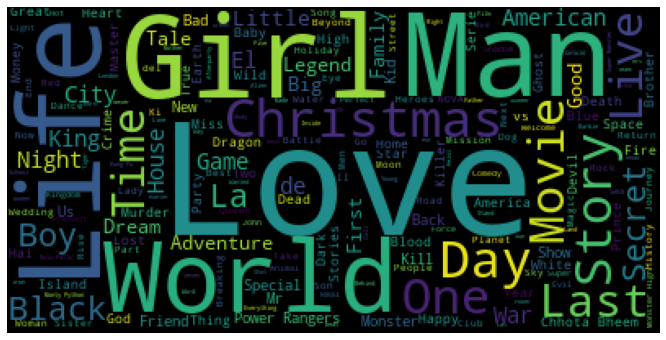

In [ ]:
text = ' '.join(netflix_df.title.dropna().values)
wordcloud = WordCloud(background_color = 'black').generate(text)
plt.figure(figsize=(15, 6))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

#### 3.2.3.2 Variabel Director

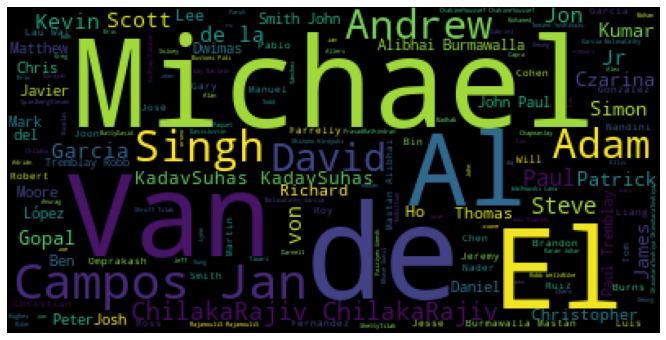

In [ ]:
text = ''.join(netflix_df.director.dropna().values)
wordcloud = WordCloud(background_color = 'black').generate(text)
plt.figure(figsize=(15, 6))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

#### 3.2.3.3 Variabel cast

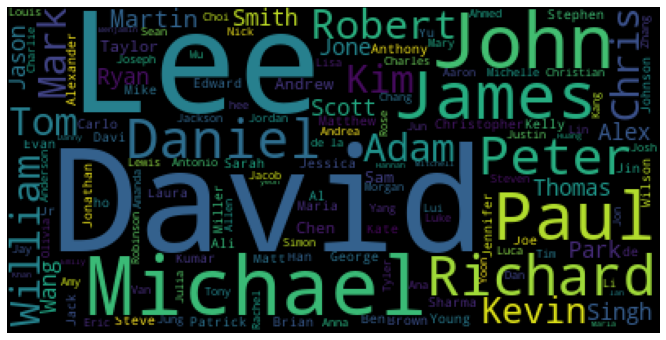

In [ ]:
text = ','.join(netflix_df.cast.dropna().values)
wordcloud = WordCloud(background_color = 'black').generate(text)
plt.figure(figsize=(15, 6))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

#### 3.2.3.4 Variabel Description

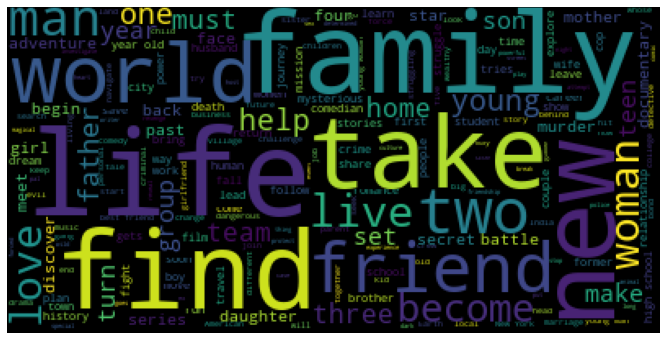

In [ ]:
text = ' '.join(netflix_df.description.dropna().values)
wordcloud = WordCloud(background_color = 'black').generate(text)
plt.figure(figsize=(15, 6))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

#4. Persiapan Data *(Data Preparation)*

Persiapan Data *(Data Preparation)* adalah proses mengubah atau mentransformasi fitur-fitur data ke dalam bentuk yang mudah diinterpretasikan dan diproses oleh model *machine learning*.

## 4.1 Features List

Kami akan membuat daftar fitur yang akan kami gunakan. Kami hanya akan menggunakan fitur yang paling relevan bagi kami, mengingat masalah yang kami hadapi. Oleh karena itu, fitur yang kami pilih adalah title, type, director, cast, country, listed_in, description, dan rating.

Selain itu, kami mengubah tipe data menjadi string dan melakukan sedikit preprocessing data dan mengganti setiap baris yang memiliki nilai NaN dengan spasi/string kosong, sehingga tidak menghasilkan kesalahan saat menjalankan kode.

In [ ]:
# Memilih fitur yang akan dipilih
content_cols = ['title','type','director','cast','country','listed_in','description','rating']
data = netflix_df[content_cols]

# Mengubah tipe data ke string
data = data.astype(str)

# Mengisi NaN dengan spasi/string kosong
data = data.fillna(" ")
data

,title,type,director,cast,country,listed_in,description,rating
0,Dick Johnson Is Dead,Movie,Kirsten Johnson,nan,United States,Documentaries,"As her father nears the end of his life, filmm...",PG-13
1,Blood & Water,TV Show,nan,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t...",TV-MA
2,Ganglands,TV Show,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",nan,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...,TV-MA
3,Jailbirds New Orleans,TV Show,nan,nan,nan,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo...",TV-MA
4,Kota Factory,TV Show,nan,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...,TV-MA
...,...,...,...,...,...,...,...,...
8802,Zodiac,Movie,David Fincher,"Mark Ruffalo, Jake Gyllenhaal, Robert Downey J...",United States,"Cult Movies, Dramas, Thrillers","A political cartoonist, a crime reporter and a...",R
8803,Zombie Dumb,TV Show,nan,nan,nan,"Kids' TV, Korean TV Shows, TV Comedies","While living alone in a spooky town, a young g...",TV-Y7
8804,Zombieland,Movie,Ruben Fleischer,"Jesse Eisenberg, Woody Harrelson, Emma Stone, ...",United States,"Comedies, Horror Movies",Looking to survive in a world taken over by zo...,R
8805,Zoom,Movie,Peter Hewitt,"Tim Allen, Courteney Cox, Chevy Chase, Kate Ma...",United States,"Children & Family Movies, Comedies","Dragged from civilian life, a former superhero...",PG


## 4.2 _Data Cleaning_

Kami menggunakan RAKE-NLTK. RAKE (Rapid Automatic Keyword Extraction) adalah algoritma ekstraksi kata kunci independen domain yang mencoba menentukan frasa kunci dalam tubuh teks dengan menganalisis frekuensi kemunculan kata dan kemunculannya bersama dengan kata lain dalam teks.

Kemudian digabungkan fitur berupa type, director, cast, country, listed_in, description, dan rating menjadi satu yaitu key_notes dan title tetap menjadi fitur sendiri.

Setelah itu, kami mengubah tipe data menjadi string dan membuang tanda baca seperti , & - . Dan menjadikan semua string menjadi huruf kecil dengan lower.

In [ ]:
# Inisialisasi awal rake
rake = Rake()

# Membuat fitur baru key_notes
data['key_notes'] = ''

# Data Cleaning
for index,row in data.iterrows():
    plot = row['description']
    
    rake.extract_keywords_from_text(plot)
    keyword_score = rake.get_word_degrees()
    
    types = ' '.join(row['type'].replace(' ','').split(',')).lower()
    genre = ''.join(row['listed_in'].split(',')).lower()
    director = ''.join(row['director'].replace(' ','').split(',')).lower()
    cast = ' '.join(row['cast'].replace(' ','').split(',')).lower()
    country = ''.join(row['country'].replace(' ','').split(',')).lower()
    rating = ' '.join(row['rating'].replace(' ','').split(',')).lower()
    keyword_score = ' '.join(list(keyword_score.keys()))
    
    row['key_notes'] = types + ' ' + genre + ' ' + director + ' ' + cast + ' ' + keyword_score + ' ' + country + ' ' + rating

# Hanya menggunakan fitur title dan key_notes
recommend = data[['title','key_notes']]
recommend.head()

,title,key_notes
0,Dick Johnson Is Dead,movie documentaries kirstenjohnson nan father ...
1,Blood & Water,tvshow international tv shows tv dramas tv mys...
2,Ganglands,tvshow crime tv shows international tv shows t...
3,Jailbirds New Orleans,tvshow docuseries reality tv nan nan feuds fli...
4,Kota Factory,tvshow international tv shows romantic tv show...


# 5. Pembuatan Model *(Modeling)*

Pada tahap ini, kita menggunakan _Content Based Filtering_ dengan CountVectorizer dan TF-IDF Vectorizer.

### 5.1 CountVectorizer

Count Vectorizer adalah cara untuk mengubah serangkaian string tertentu menjadi representasi frekuensi. Count Vectorizer dapat membantu dalam memahami jenis teks dengan frekuensi kata-kata di dalamnya. Namun mempunyai kelemahan berupa:
1. Ketidakmampuan dalam mengidentifikasi kata-kata yang lebih penting dan kurang penting untuk dianalisis.
2. Hanya mempertimbangkan kata-kata yang berlimpah di corpus sebagai kata yang paling signifikan secara statistik.
3. Tidak mengindentifikasi hubungan antar kata seperti kesamaan linguistik antar kata.

#### 5.1.1 Pembuatan CountVectorizer

Di definisikan variabel vectorizer sebagai CountVectorizer(), dengan stop_words=’english’ berfungsi untuk menghilangkan kata semacam: i, you, the, a, this, is dan sejenisnya.

In [ ]:
# Inisialisasi CountVectorizer
cv= CountVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')

# Melakukan perhitungan idf pada data 
cv.fit(recommend['title'])

# Melakukan fit lalu ditransformasikan ke bentuk matrix
cvidf_matrix = cv.fit_transform(recommend['key_notes']) 

In [ ]:
# Melihat ukuran matrix cv-idf
cvidf_matrix.shape

(8807, 242913)

### 5.2 TF-IDF Vectorizer

TF-IDF Vectorizer (Term Frequency -  Inverse Document Frequency) adalah statistik yang didasarkan pada frekuensi kata dalam korpus tetapi juga memberikan representasi numerik tentang betapa pentingnya sebuah kata untuk analisis statistik.

TF-IDF lebih baik daripada Count Vectorizers karena tidak hanya berfokus pada frekuensi kata yang ada dalam korpus tetapi juga memberikan pentingnya kata tersebut. Kami kemudian dapat menghapus kata-kata yang kurang penting untuk analisis, sehingga membuat model bangunan kurang kompleks dengan mengurangi dimensi input.

TF-IDF didasarkan pada logika bahwa kata-kata yang terlalu banyak dalam korpus dan kata-kata yang terlalu jarang keduanya tidak penting secara statistik untuk menemukan suatu pola. Faktor logaritma dalam TF-IDF secara matematis menghukum kata-kata yang terlalu banyak atau terlalu jarang dalam korpus dengan memberikan nilai TF-IDF yang rendah.

#### 5.2.1 Pembuatan TF-IDF Vectorizer

Di definisikan variabel vectorizer sebagai TfidfVectorizer(), dengan stop_words=’english’ berfungsi untuk menghilangkan kata semacam: i, you, the, a, this, is dan sejenisnya.

In [ ]:
# Inisialisasi TfidfVectorizer
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')

# Melakukan perhitungan idf pada data 
tf.fit(recommend['title'])

# Melakukan fit lalu ditransformasikan ke bentuk matrix
tfidf_matrix = tf.fit_transform(recommend['key_notes']) 

In [ ]:
# Melihat ukuran matrix tf-idf
tfidf_matrix.shape

(8807, 242913)

# 6. Evaluasi Model

## 6.1 Evalusasi Model dengan Cosine Similarity CountVectorizer

Cosine similarity mengukur kesamaan antara dua vektor dan menentukan apakah kedua vektor tersebut menunjuk ke arah yang sama. Ia menghitung sudut cosinus antara dua vektor. Semakin kecil sudut cosinus, semakin besar nilai cosine similarity. 

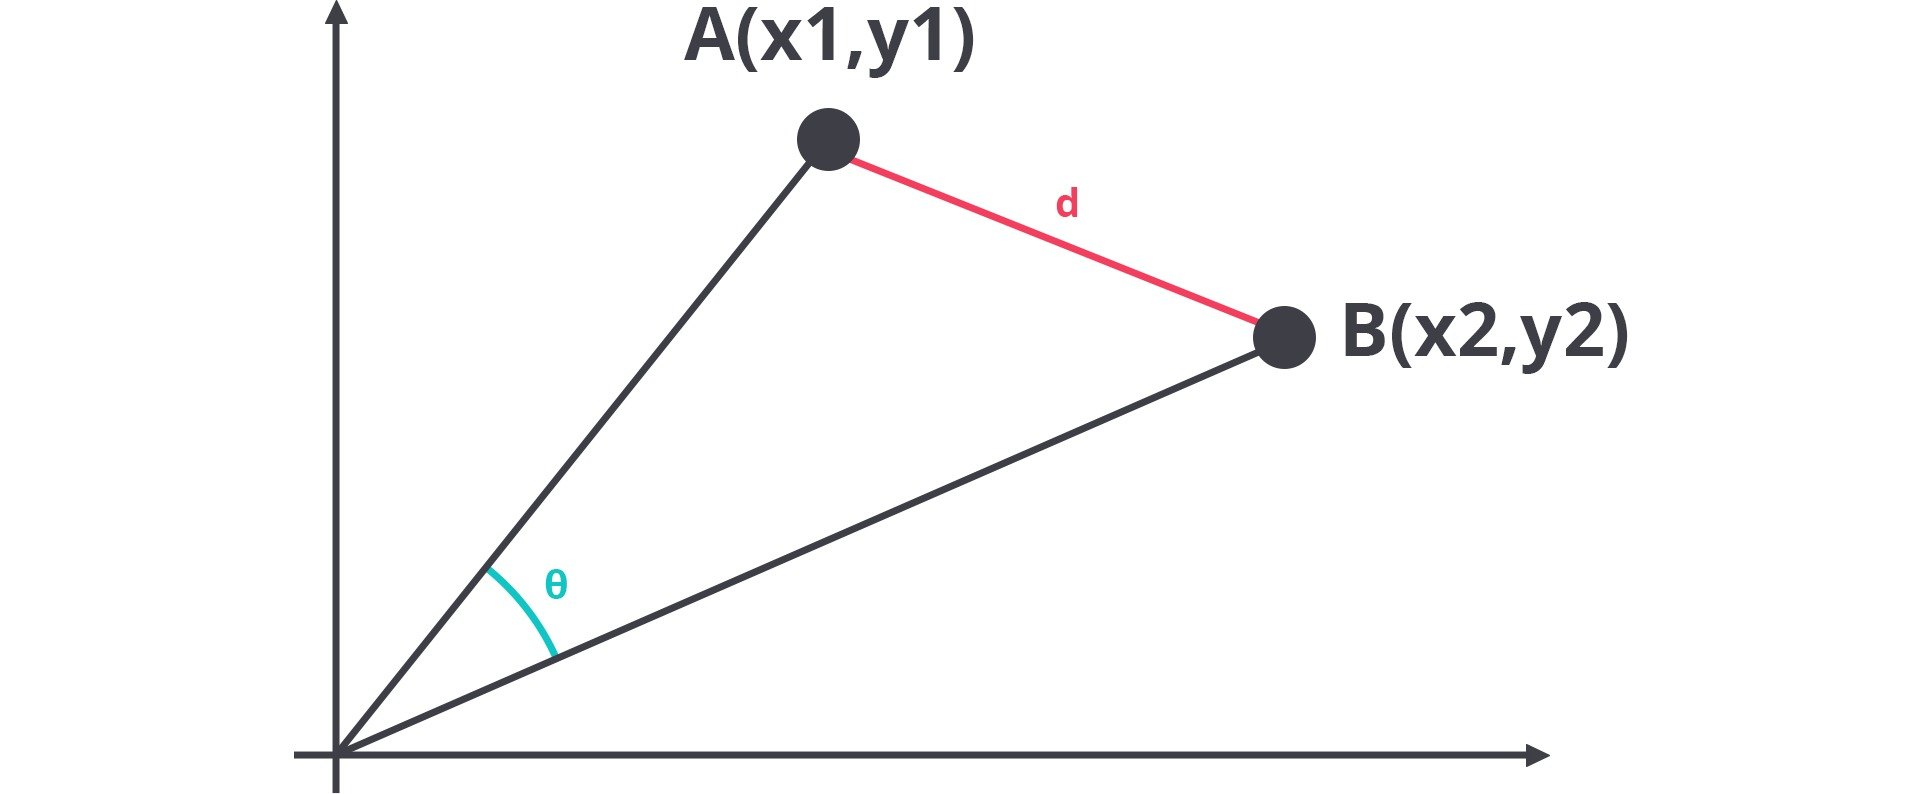

Cosine similarity dirumuskan sebagai berikut.

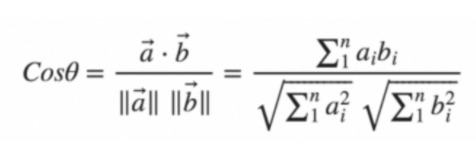

In [ ]:
# Menghitung cosine similarity pada matrix cv-idf
cosine_sim = cosine_similarity(cvidf_matrix, cvidf_matrix) 
cosine_sim

array([[1.        , 0.01488234, 0.01581337, ..., 0.04189458, 0.09762721,
        0.01891512],
       [0.01488234, 1.        , 0.27322953, ..., 0.        , 0.        ,
        0.0726273 ],
       [0.01581337, 0.27322953, 1.        , ..., 0.        , 0.01327681,
        0.07717082],
       ...,
       [0.04189458, 0.        , 0.        , ..., 1.        , 0.07034887,
        0.03407496],
       [0.09762721, 0.        , 0.01327681, ..., 0.07034887, 1.        ,
        0.04764306],
       [0.01891512, 0.0726273 , 0.07717082, ..., 0.03407496, 0.04764306,
        1.        ]])

In [ ]:
# Membuat dataframe dari variabel cosine_sim dengan baris dan kolom berupa title
cosine_sim_df = pd.DataFrame(cosine_sim, index=recommend['title'], columns=recommend['title'])
print('Shape:', cosine_sim_df.shape)
 
# Melihat similarity matrix pada setiap title
cosine_sim_df.sample(5, axis=1).sample(10, axis=0)

Shape: (8807, 8807)


title,The Irregulars,The Ministry of Time,IBOY,Revolutionary Love,Security
title,,,,,
Sugar Rush,0.158570,0.167651,0.039352,0.167436,0.038159
Beyond Skyline,0.000000,0.038115,0.098414,0.000000,0.015905
Evvarikee Cheppoddu,0.095836,0.065795,0.101929,0.086738,0.098840
Containment,0.179090,0.196723,0.095238,0.216118,0.107743
Thor: Tales of Asgard,0.051169,0.049181,0.047619,0.054029,0.061568
Stories by Rabindranath Tagore,0.304030,0.292218,0.065609,0.334985,0.079526
Ek Ladki Ko Dekha Toh Aisa Laga,0.086831,0.059613,0.076960,0.091686,0.149254
Train to Busan,0.059419,0.114220,0.117966,0.112933,0.114391
BuyBust,0.061117,0.117485,0.106170,0.090347,0.102952


## 6.2 Melakukan Rekomendasi dan Metrik Precision

In [ ]:
titles = recommend['title']
indices = pd.Series(recommend.index, index=recommend['title'])

In [ ]:
def recomendation(title:str):
  idx = indices[title]
  sim_scores = list(enumerate(cosine_sim[idx]))
  sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
  sim_scores = sim_scores[1:26]
  movie_indices = [i[0] for i in sim_scores]
  sim_values = [i[1]for i in sim_scores]
  print(f'Movie atau TV Show yang anda sukai {title}\n{len(sim_scores)} Movie atau TV Show berikut ini mungkin anda sukai:\n')
  return pd.DataFrame(data = {"Nama Movie atau TV Show" : titles.iloc[movie_indices], "Cosine Similarity" : sim_values}).sort_values(by='Cosine Similarity',ascending=False).reset_index(drop=True), sim_values

In [ ]:
def precision(gr,sv):
  result = []
  gr = len(gr)
  sv = sv[:gr]
  for x in sv:
    if x>0.05:
      result.append(x)
  results = len(result)
  precision = results/gr
  print("Jumlah Rekomendasi Film yang sesuai: ", len(result))
  print("Banyaknya Rekomendasi Film: ", gr)
  return print('Precision adalah',round(precision,2))

In [ ]:
gr,sv = recomendation("Story of Kale: When Someone's in Love")
gr

Movie atau TV Show yang anda sukai Story of Kale: When Someone's in Love
25 Movie atau TV Show berikut ini mungkin anda sukai:



,Nama Movie atau TV Show,Cosine Similarity
0,Chaotic Love Poems,0.310761
1,Galih dan Ratna,0.306491
2,Verses of Love,0.301739
3,Iyore,0.300042
4,Posesif,0.290360
5,Shubh Aarambh,0.288301
6,Geez & Ann,0.288105
7,Milea,0.285858
8,Love Like the Falling Rain,0.283373
9,Dilan 1991,0.283373


Metrik Precision

In [ ]:
precision(gr,sv)

Jumlah Rekomendasi Film yang sesuai:  25
Banyaknya Rekomendasi Film:  25
Precision adalah 1.0


## 6.3 Evaluasi Model dengan Cosine Similarity TF-IDF Vectorizer

Cosine similarity mengukur kesamaan antara dua vektor dan menentukan apakah kedua vektor tersebut menunjuk ke arah yang sama. Ia menghitung sudut cosinus antara dua vektor. Semakin kecil sudut cosinus, semakin besar nilai cosine similarity. 

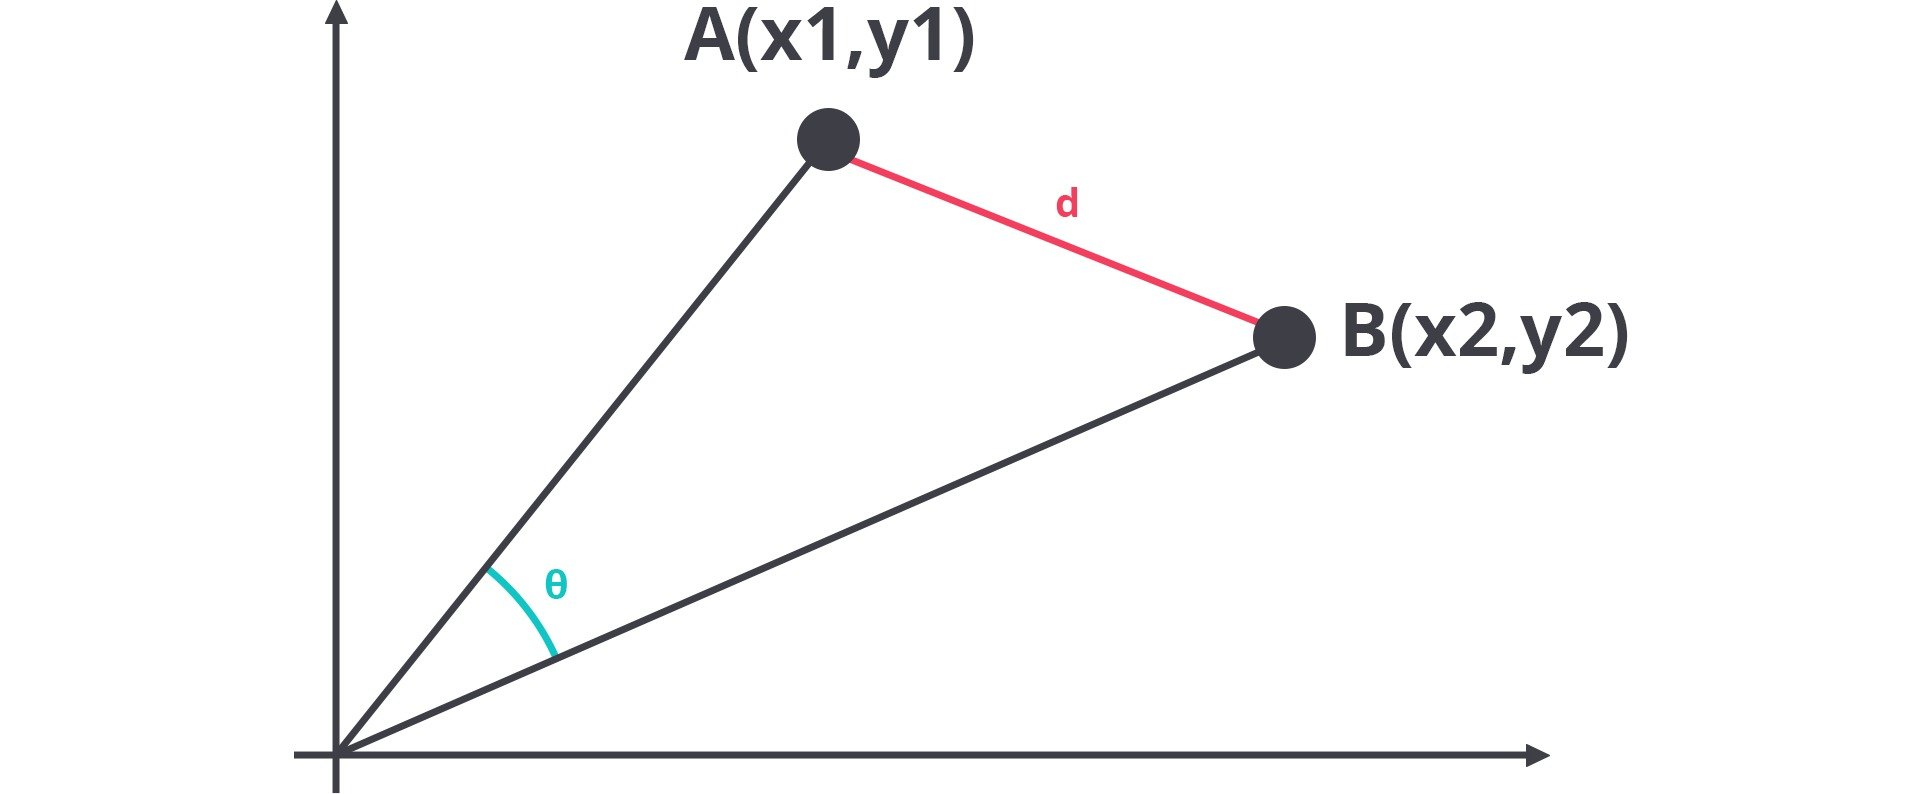

Cosine similarity dirumuskan sebagai berikut.

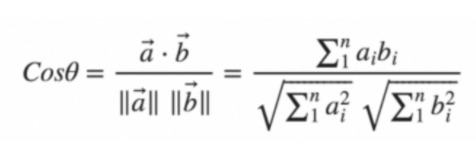

In [ ]:
# Menghitung cosine similarity pada matrix tf-idf
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix) 
cosine_sim

array([[1.00000000e+00, 1.00481620e-03, 1.20152382e-03, ...,
        2.29347818e-03, 1.34228908e-02, 6.43164484e-04],
       [1.00481620e-03, 1.00000000e+00, 1.85410327e-02, ...,
        0.00000000e+00, 0.00000000e+00, 2.92868896e-03],
       [1.20152382e-03, 1.85410327e-02, 1.00000000e+00, ...,
        0.00000000e+00, 2.26879086e-03, 4.79228324e-03],
       ...,
       [2.29347818e-03, 0.00000000e+00, 0.00000000e+00, ...,
        1.00000000e+00, 4.18852766e-03, 1.37877467e-03],
       [1.34228908e-02, 0.00000000e+00, 2.26879086e-03, ...,
        4.18852766e-03, 1.00000000e+00, 3.71833840e-03],
       [6.43164484e-04, 2.92868896e-03, 4.79228324e-03, ...,
        1.37877467e-03, 3.71833840e-03, 1.00000000e+00]])

In [ ]:
# Membuat dataframe dari variabel cosine_sim dengan baris dan kolom berupa title
cosine_sim_df = pd.DataFrame(cosine_sim, index=recommend['title'], columns=recommend['title'])
print('Shape:', cosine_sim_df.shape)
 
# Melihat similarity matrix pada setiap title
cosine_sim_df.sample(5, axis=1).sample(10, axis=0)

Shape: (8807, 8807)


title,North & South,Fire in Paradise,Clair Obscur,Küçük Esnaf,Revolutionary Love
title,,,,,
Pedal the World,0.001250,0.013643,0.008670,0.008378,0.005964
Winter Sun,0.026523,0.006059,0.006255,0.027041,0.030634
The Price of Success,0.004189,0.003941,0.012613,0.006343,0.005088
The Irregulars,0.045435,0.003401,0.002747,0.002655,0.054665
Abby Sen,0.002957,0.001574,0.008024,0.008182,0.004210
Triple Frontier,0.000000,0.002563,0.000639,0.000618,0.000000
Pet Sematary 2,0.006374,0.009774,0.001416,0.001368,0.001135
It Comes at Night,0.010885,0.002447,0.002445,0.008337,0.006538
Dogs,0.006210,0.010677,0.000679,0.000656,0.008345


## 6.4 Melakukan Rekomendasi dan Metrik Precision

In [ ]:
titles = recommend['title']
indices = pd.Series(recommend.index, index=recommend['title'])

In [ ]:
def recomendation(title:str):
  idx = indices[title]
  sim_scores = list(enumerate(cosine_sim[idx]))
  sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
  sim_scores = sim_scores[1:26]
  movie_indices = [i[0] for i in sim_scores]
  sim_values = [i[1]for i in sim_scores]
  print(f'Movie atau TV Show yang anda sukai {title}\n{len(sim_scores)} Movie atau TV Show berikut ini mungkin anda sukai:\n')
  return pd.DataFrame(data = {"Nama Movie atau TV Show" : titles.iloc[movie_indices], "Cosine Similarity" : sim_values}).sort_values(by='Cosine Similarity',ascending=False).reset_index(drop=True), sim_values

In [ ]:
def precision(gr,sv):
  result = []
  gr = len(gr)
  sv = sv[:gr]
  for x in sv:
    if x>0.05:
      result.append(x)
  results = len(result)
  precision = results/gr
  print("Jumlah Rekomendasi Film yang sesuai: ", len(result))
  print("Banyaknya Rekomendasi Film: ", gr)
  return print('Precision adalah',round(precision,2))

In [ ]:
gr,sv = recomendation("Story of Kale: When Someone's in Love")
gr

Movie atau TV Show yang anda sukai Story of Kale: When Someone's in Love
25 Movie atau TV Show berikut ini mungkin anda sukai:



,Nama Movie atau TV Show,Cosine Similarity
0,One Day We'll Talk About Today,0.091851
1,Surat Dari Praha,0.083367
2,Filosofi Kopi The Movie,0.066933
3,Cahaya Dari Timur Beta Maluku,0.064952
4,Geez & Ann,0.064708
5,Chaotic Love Poems,0.064605
6,Soekarno,0.060272
7,Posesif,0.057856
8,Milea,0.056396
9,Galih dan Ratna,0.054571


Metrik Precision

In [ ]:
precision(gr,sv)

Jumlah Rekomendasi Film yang sesuai:  15
Banyaknya Rekomendasi Film:  25
Precision adalah 0.6


# Penutup

Dari precision yang dilihat bahwa precision pada CountVectorizer lebih baik daripada TF-IDF Vectorizer. Precision pada CountVectorizer 1.0 artinya 100% sedangkan precision pada TF-IDF Vectorizer 0.6 atau 60%.

**Referensi**
*   Dokumentasi Scikit-Learn: https://scikit-learn.org/stable/modules/classes.html
*   Dataset: https://www.kaggle.com/shivamb/netflix-shows